<a href="https://colab.research.google.com/github/nayoung718/essa_python_1/blob/main/%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EC%99%84%EB%B2%BD_%EA%B0%80%EC%9D%B4%EB%93%9C_ch8_10_pg_544~561_%ED%95%84%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 파이썬 머신러닝 완벽 가이드 ch8.10 pg. 544 ~ 561 필사

## 10. 텍스트 분석 실습 - 캐글 Mercari Price Suggestion Challenge

- 일본 대형 온라인 쇼핑몰 Mercari사의 제품에 대해 가격 예측하는 과제 -> 제품 속성, 설명 등의 텍스트 데이터로 구성됨

데이터 세트 속성 : train_id, name, item_condition_id, category_name, brand_name, price, shipping, item_description

-> price : 예측해야할 타깃 값

- 데이터 전처리

In [25]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

mercari_df=pd.read_csv('/train.tsv', sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & Parts,Razer,52.0,0,This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,"Adorable top with a hint of lace and a key hole in the back! The pale pink is a 1X, and I also have a 3X available in white!"


In [26]:
#피처 타입과 null 여부 확인
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482529 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


<Figure size 600x400 with 0 Axes>

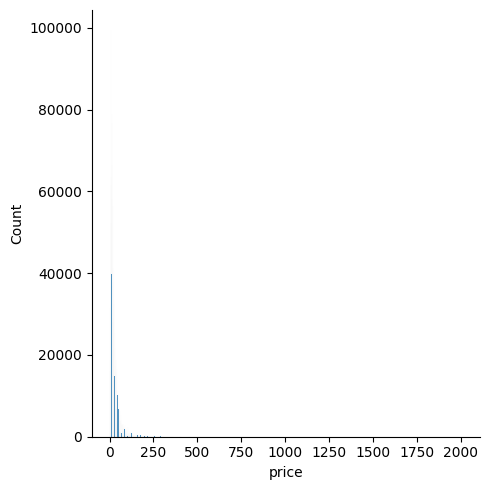

In [27]:
#brand_name 칼럼 많은 null값 -> 가격에 영향을 미치는 중요 요인으로 판단되지만 null이 많음-> null 적절한 문자열로 치환
#target 값인 price 칼럼 데이터 분포도 보기 ->왜곡돼있을 경우 로그 변환

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

y_train_df=mercari_df['price']
plt.figure(figsize=(6,4))
sns.displot(y_train_df, kde=False)

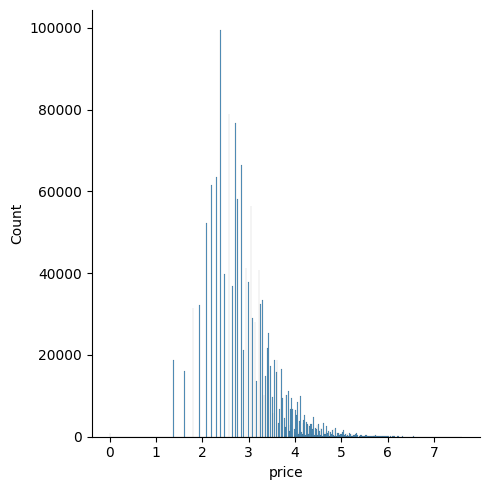

In [28]:
#적은 가격을 가진 데이터 값에 왜곡돼 분포 -> 로그 변환
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.displot(y_train_df, kde=False)

In [29]:
#비교적 정규분포에 가까워짐-> 로그 변환으로 변경
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

0    2.397895
1    3.970292
2    2.397895
Name: price, dtype: float64

In [30]:
# shipping, item_condition_id
print('Shopping 값 유형: \n', mercari_df['shipping'].value_counts())
print('item_condition_id 값 유형: \n', mercari_df['item_condition_id'].value_counts())

Shopping 값 유형: 
 shipping
0    819435
1    663100
Name: count, dtype: int64
item_condition_id 값 유형: 
 item_condition_id
1    640549
3    432161
2    375479
4     31962
5      2384
Name: count, dtype: int64


In [31]:
#shipping 배송비 유무, 균일 / item_condition_id 제품상태(1,2,3..) null값 별로 없지만 별도 설명 없을 경우 no description yet
# 얼마나 있는지 확인
boolean_cond = mercari_df['item_description'] == 'No description yet'
mercari_df[boolean_cond]['item_description'].count()
## No description yet : null같이 의미있는 속성값으로 사용 불가하니 적절한 값으로 변경

82489

In [32]:
#category_name : /로 분리된 카테고리를 하나의 문자열로 -> /기준 단어 토큰화후 별도 피처로 저장해 알고리즘 학습
#split_cat() 이용 / error except catch 하여 대, 중, 소 분류 모두 other null 부여

#apply lambda에서 호출되는 대, 중, 소 분할 함수 생성, 대, 중, 소 값을 리스트로 변환
def split_cat(category_name):
  try:
    return category_name.split('/')
  except:
    return ['Other_Null', 'Other_Null', 'Other_Null']

#위의 split_cat()을 apply lambda에서 호출해 대, 중, 소 칼럼을 mercari_df 에 생성.
mercari_df["cat_dae"], mercari_df["cat_jung"], mercari_df["cat_so"] = \
                      zip(*mercari_df["category_name"].apply(lambda x: split_cat(x)))

#대분류만 값의 유형과 건수를 살펴보고, 중분류, 소분류는 값의 유형이 많으므로 분류 개수만 추출
print('대분류 유형: \n', mercari_df['cat_dae'].value_counts())
print('중분류 개수:', mercari_df['cat_jung'].nunique())
print('소분류 개수:', mercari_df['cat_so'].nunique())

대분류 유형: 
 cat_dae
Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: count, dtype: int64
중분류 개수: 114
소분류 개수: 871


In [33]:
#brand_name, category_name, item_description 칼럼의 null 값은 일괄적으로 other null로 동일하게 변경
#brand_name null 값 다른 값으로 변경하는 것은 적절하지 않으므로 other_null로 변경
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

#각 칼럼별로 Null 값 건수 확인. 모두 0이 나와야 합니다.
mercari_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

- 피처 인코딩과 피처 벡터화

문자열 칼럼 중 레이블/원-핫 인코딩 수행하거나 피처 벡터화로 변환할 칼럼 선별

상품 가격 예측 -> 회귀 모델 기반

-> 선형 회귀 모델, 회귀 트리 모델 적용 예정 -> 원핫 인코딩 적용 선호

피처 벡터화 : 짧은 텍스트 = count 기반 벡터화, 긴 텍스트 = td-idf 기반 벡터화 적용

In [34]:
#brand_name 어떤 유형, 유형 건수와 대표 브랜드명 보기

print('brand name의 유형 건수:', mercari_df['brand_name'].nunique())
print('brand name sample 5건: \n', mercari_df['brand_name'].value_counts()[:5])

#brand_name 대부분 명료한 문자열 -> 별도 피처 벡터화 형태로 만들 필요 없이 원핫인코딩

brand name의 유형 건수: 4810
brand name sample 5건: 
 brand_name
Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: count, dtype: int64


In [35]:
#name 유형건수, 상품명 보기
print('name의 종류 개수:', mercari_df['name'].nunique())
print('name sample 7건: \n', mercari_df['name'][:7])
##name 유형 매우 많고 적은 단어 위주의 텍스트 형태-> count기반 피처 벡터화, 원핫 인코딩

name의 종류 개수: 1225273
name sample 7건: 
 0    MLB Cincinnati Reds T Shirt Size XL
1       Razer BlackWidow Chroma Keyboard
2                         AVA-VIV Blouse
3                  Leather Horse Statues
4                   24K GOLD plated rose
5       Bundled items requested for Ruie
6     Acacia pacific tides santorini top
Name: name, dtype: object


In [36]:
# item_description

pd.set_option('max_colwidth', 200)

#item_description의 평균 문자열 크기
print('item_description 평균 문자열 크기:', mercari_df['item_description'].str.len().mean())

mercari_df['item_description'][:2]

## 문자열이 비교적 크므로 TF-IDF 변환

item_description 평균 문자열 크기: 145.71139703278507


0                                                                                                                                                                              No description yet
1    This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
Name: item_description, dtype: object

In [37]:
#주요 칼럼 인코딩 및 피처 벡터화 변환

#name 속성에 대한 피처 벡터화 변환
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)


#item_description에 대한 피처 벡터화 변환
tfidf_descp = TfidfVectorizer(max_features=50000, ngram_range=(1,3), stop_words="english")
X_descp = tfidf_descp.fit_transform(mercari_df["item_description"])

print("name vectorization shape:", X_name.shape)
print("item_description vectorization shape:", X_descp.shape)

name vectorization shape: (1482535, 105757)
item_description vectorization shape: (1482535, 50000)


인코딩 대상 칼럼도 희소 행렬 형태로 인코딩 적용 후 결합

-> LabelBinarizer 이용해 희소 행렬 형태로 인코딩 -> sparse모듈의 hstack() 이용해 결합

In [38]:
#LabelBinarizer 로 원핫 인코딩 변환
from sklearn.preprocessing import LabelBinarizer

#brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환

lb_brand_name = LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df["brand_name"])
lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df["item_condition_id"])
lb_shipping= LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df["shipping"])

# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae = lb_cat_dae.fit_transform(mercari_df["cat_dae"])
lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df["cat_jung"])
lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df["cat_so"])

#제대로 변환됐는지 생성된 인코딩 데이터셋의 타입과 shape 보기
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print("X_brand shape: {0}, X_item_cond_id shape: {1}".format(X_brand.shape, X_item_cond_id.shape))
print("X_shipping shape : {0}, X_cat_dae shape: {1}".format(X_shipping.shape, X_cat_dae.shape))
print("X_cat_jung shape: {0}, X_cat_so shape: {1}".format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'>
X_brand shape: (1482535, 4810), X_item_cond_id shape: (1482535, 5)
X_shipping shape : (1482535, 1), X_cat_dae shape: (1482535, 11)
X_cat_jung shape: (1482535, 114), X_cat_so shape: (1482535, 871)


인코딩 변환된 데이터 셋이 CSR 형태로 변환된 csr_matrix 타입
brand_name 유형 4810개 -> 원핫 인코딩 후 4810개의 인코딩 칼럼

-> 인코딩 칼럼 많이 생겼지만 피처 벡터화로 텍스트 형태의 문자열이 가지는 벡터 형태의 매우 많은 칼럼과 함께 결합되므로 문제 없음

-> 희소 인코딩 변환된 데이터셋, 피처벡터화 변환한 데이터 셋 hstack()으로 결합

- 메모리 많이 사용하니 삭제하며 사용

In [39]:
from scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id,\
                     X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

#hstack 함수를 이용해 인코딩과 벡터화를 수행한 데이터 세트를 모두 결합.
X_features_sparse = hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

#데이터 세트가 메모리를 많이 차지하므로 사용 목적이 끝났으면 바로 메모리에서 삭제.
del X_features_sparse
gc.collect()

<class 'scipy.sparse._csr.csr_matrix'> (1482535, 161569)


0

- 릿지 회귀 모델 구축 및 평가

모델 평가하는 평가 로직 함수화 : RSMLE 방식 이용

학습 모델이 사용할 price값은 로그변환된 값이므로 예측도 로그변환된 값으로 예측 -> 다시 로그 역변환인 지수 변환 수행해야함

In [40]:
def rmsle(y, y_pred):
  #underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산
  return np.sqrt(np.mean(np.power(np.log1p(y)- np.log1p(y_pred), 2)))

def evaluate_org_price(y_test, preds):

    #원본 데이터는 log1p로 변환되었으므로 exmpm1로 원복 필요.
    preds_exmpm = np.expm1(preds)
    y_test_exmpm = np.expm1(y_test)

    #rmsle로 RMSLE 값 추출
    rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
    return rmsle_result

In [41]:
# 학습용 데이터 생성, 모델 학습/예측 로직 별도의 함수로 만들기

import gc
from scipy.sparse import hstack

def model_train_predict(model, matrix_list):
    #scipy.sparse 모듈의 hstack을 이용해 희소행렬 결합
    X = hstack(matrix_list).tocsr()
    X_train, X_test, y_train, y_test = train_test_split(X, mercari_df["price"],
                                                      test_size=0.2, random_state=156)
    #모델 학습 및 예측
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    del X, X_train, X_test, y_train
    gc.collect()

    return preds, y_test

In [42]:
# Ridge 이용해 mercari price 회귀 예측 수행
#가격 예측에 item_description같은 텍스트 형태 속성 얼마나 영향 미치는지 알아보기 (포함된경우와 안된경우 예측성능 비교)

linear_model = Ridge(solver="lsqr", fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id,\
                     X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print("Item Description을 제외했을 때 rmsle 값:", evaluate_org_price(y_test, linear_preds))

sparse_matrix_list = ( X_descp, X_brand, X_item_cond_id,\
                     X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print("Item Description을 포함했을 때 rmsle 값:", evaluate_org_price(y_test, linear_preds))

Item Description을 제외했을 때 rmsle 값: 0.4983990938999374
Item Description을 포함했을 때 rmsle 값: 0.5109118267040581


- LightGMB 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가

In [ ]:
from lightgbm import LGBMRegressor

sparse_matrix_list = ( X_descp, X_brand, X_item_cond_id,
                     X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds, y_test = model_train_predict(model=lgbm_model, matrix_list=sparse_matrix_list)
print("LightGBM rmsle 값:", evaluate_org_price(y_test, lgbm_preds))

In [ ]:
## Ridge보다 예측 성능이 더 나아짐. 여기에 ridge 예측 결과값 앙상블해 최종 예측 결괏값 도출

preds = lgbm_preds*0.45 + linear_preds*0.55
print("LightGBM과 Ridge를 ensemble한 최종 rmsle 값:", evaluate_org_predict(y_test,preds))

앙상블 방식으로 예측 성능 개선

- 정리

- 텍스트 분석을 위한 기반 프로세스 : 텍스트 분류, 감성분석, 토픽 모델링, 텍스트 군집화 및 유사도 측정

텍스트 정규화 -> 피처 벡터화로 변환 -> ml 모델 학습, 예측, 평가

텍스트 분류, 감성 분석 : 지도학습 방식 기반

텍스트 군집화 : k평균 군집화 이용, 코사인 유사도 이용

mercari price challenge -> 정형 피처들과 비정형 피처 결합해 회귀 예측 모델 구현